# $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ΑΣΚΗΣΗ 2
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$Βασίλης Πουλος, 2805
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$Κωστάκης Ελευθέριος-Παναγιώτης, 2741<br>

# Step 1

In [1]:
import pandas as pd
import numpy as np
import json
import time

start = time.time()
# Store all businesses
data = [json.loads(line) for line in 
        open('/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_business.json', 'r')]

stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 0.056 mins


In [2]:
# Keep businesses which are located in Toronto
data = [x for x in data if x['city']=='Toronto']
data = np.array(data) # Convert list to numpy array

# Create an array with Toronto located businesses with more than 15 reviews
business_col = np.array([])
for i in range(len(data)):
    if data[i]['review_count']>=15:
        business_col = np.append(business_col,data[i]['business_id'])

In [3]:
# Helping function to check if a business is in business_col (Toronto and >=15 reviews)
def get_business_index(business_id):
    return np.where(business_col == business_id)[0]

In [5]:
start = time.time()

user_business = []
# Read the json review file line by line and keep the reviews referring to business_col 
with open('/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_review.json','r',encoding="utf8") as reviews_file:

    for line in reviews_file:
        line = json.loads(line)
        ind = get_business_index(line['business_id'])

        if ind.size>0:
            user_business.append([line['user_id'],line['business_id'], line['stars']])
            
stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 10.570 mins


In [6]:
# User business have all the reviews we want. But using numpy unique will keep the first occurency.
# We want to keep last occurency, so a smart way to do so is to read our list with all pairs of 
# type (UserID, BusinessID, Rating) upside-down(reverse). Then call unique and reconstruct the 
# total reviews with the give indices.
user_business.reverse()
from operator import itemgetter
user_bus_sorted = sorted(user_business, key=itemgetter(0,1))

user_bus_sorted = np.array(user_bus_sorted)
pairs = user_bus_sorted[:,0:2]
_, idx = np.unique(pairs, axis=0, return_index=True)
total_reviews = user_bus_sorted[idx]

In [7]:
# Take the userID column and keep the unique users. Do a for-loop to keep users with >=15 reviews.
users = total_reviews[:,0]
unique_users, counts = np.unique(users, return_counts=True)
uniq_users = []

for i in range(len(unique_users)):
    if counts[i]>=15:
        uniq_users.append(unique_users[i])
uniq_users = np.array(uniq_users)

# Here keep the unique businesses column
businesses = total_reviews[:,1]
unique_businesses = np.unique(businesses)

start = time.time()
# Create the sparse_array using the unique users(rows) and unique businesses (columns)
sparse = np.zeros((len(unique_businesses), len(uniq_users)))
for i in range(len(unique_businesses)):
    user_index = np.where(unique_businesses[i] == total_reviews)[0]

    for j in range(len(user_index)):
        unique_user_ind = np.where(total_reviews[user_index[j]][0] == uniq_users) 
        if unique_user_ind[0].size>0:
            sparse[i][unique_user_ind[0][0]] = int(float(total_reviews[user_index[j]][2]))
            
stop = time.time()
print("Sparse array created in {:.3f} mins".format((stop-start)/60))

# Sparse array shape indicates the initial unique users and unqiue businesses
sparse.shape

Sparse array created in 2.993 mins


(7602, 5677)

In [8]:
# Prune until nothing to delete

stop=0
while(stop==0):
    # prune the rows(businesses with below 15 reviews)
    index_to_delete = []
    for i in range(sparse.shape[0]):
        nonzero_indexes = np.nonzero(sparse[i])
        if len(nonzero_indexes[0])<15:
            index_to_delete.append(i)
            
    #make new sparse array with deleted items and unique_businesses to track ids
    unique_businesses = np.delete(unique_businesses, index_to_delete)
    sparse = np.delete(sparse, index_to_delete, axis=0)
    
    #prune the columns(users)
    transposed_sparse = np.transpose(sparse)
    columns_to_delete = []
    for i in range(transposed_sparse.shape[0]):
        nonzero_values = np.nonzero(transposed_sparse[i])
        if len(nonzero_values[0])<15:
            columns_to_delete.append(i)
            
    #make new sparse array with deleted items and uniq_users to track ids
    uniq_users = np.delete(uniq_users, columns_to_delete)
    sparse = np.delete(sparse, columns_to_delete, axis=1)
    
    # If nothing to delete -> stop
    if len(index_to_delete)==0 and len(columns_to_delete)==0:
        stop=1

In [9]:
# After pruning we have our sparse array reshaped
sparse.shape

(4092, 4794)

In [11]:
# Create the new data, create a list([userID,businessID,rating]) using our sparse array data
data_csv = []
start = time.time()
for i in range(sparse.shape[1]):
    for j in range(sparse.shape[0]):
        if sparse[j][i]>0:
            data_csv.append([uniq_users[i],unique_businesses[j], sparse[j][i]])
stop = time.time()
print("Data list created in {:.3f} mins".format((stop-start)/60))

Data list created in 0.212 mins


In [12]:
# Load the target file -- we want our data_csv to be exactly the same with pruned_data.csv
table_R = pd.read_csv("pruned_data.csv", header = None)
table_list = table_R.values.tolist()

In [13]:
# To check if our data are the same we need to sort both with the same way(here by (userID,businessID) )
from operator import itemgetter
data_csv = sorted(data_csv, key=itemgetter(0,1), reverse=True)
table_R = sorted(table_list, key=itemgetter(0,1), reverse=True)

In [14]:
# Convert our lists to numpy array to check if they are exactly the same using array_equal()
table_R = np.array(table_R)
data_csv = np.array(data_csv)
np.array_equal(table_R,data_csv)

True

# Step 2

In [85]:
import pandas as pd 
import math
import numpy as np
import json

# We have the file ready from Step 1
data_table = pd.DataFrame(data_csv, columns = ['user_id', 'business_id', 'rating'])
print(data_table)

                       user_id             business_id rating
0       zzmhLxcZ4XZQyz95c_KbOA  zFR99jgMi-qzaJXIx8MXHA    4.0
1       zzmhLxcZ4XZQyz95c_KbOA  ynmTXY9yJDiNkO4HUmxRSQ    4.0
2       zzmhLxcZ4XZQyz95c_KbOA  v_UM-AW9YYTCbWUNa-w1Gg    5.0
3       zzmhLxcZ4XZQyz95c_KbOA  swM_9CXxkvxEk3fDkjA6PQ    4.0
4       zzmhLxcZ4XZQyz95c_KbOA  nktQ_aBRp5CmVOkXR0Mz1g    5.0
...                        ...                     ...    ...
197107  --BumyUHiO_7YsHurb9Hkw  5DDvJhkk3zsd9jBxDQpkow    4.0
197108  --BumyUHiO_7YsHurb9Hkw  4SyAKQevPuB4punANp41-Q    4.0
197109  --BumyUHiO_7YsHurb9Hkw  41o1FUbCYKJv2djtnlkzlg    3.0
197110  --BumyUHiO_7YsHurb9Hkw  1W_gZM_uuEvJqapbIl6z9Q    5.0
197111  --BumyUHiO_7YsHurb9Hkw  -b94nkPVLQw95zgtDhcpYA    1.0

[197112 rows x 3 columns]


In [86]:
print("Sample data should have {} rows \n".format(math.ceil(len(table_R)*0.05)))
sample_data = data_table.sample(frac=0.05)
print(len(sample_data))

Sample data should have 9856 rows 

9856


In [87]:
# Setting sample ratings to zero
for index in sample_data.index:
    data_table.at[index, 'rating'] = 0

In [88]:
# Create the numpy array, unique_users and unique_business lists
data_table_R = data_table.to_numpy()
unique_users = np.unique(data_table_R[:,0])
unique_business = np.unique(data_table_R[:,1])

#### The main idea here is to create the sparse_array row by row using and unique_business as indices. What we do is to take for every unique user all the businesses that there are ratings. So let's say we have the userID 'iamuserid1' in row 0 in unique_users, then we get all business IDS that that user has a rating. Finally we have all businessIDS indices, for example let's say 'iamuserid1' has ratings for businesses which are located in index 2,55,123,222 in unique_business array. We will use these values as our columns indices in the sparse_array, so we have to assign ratings at sparse(0,2), sparse(0,55), sparse(0,123), sparse(0,222) .. etc. for every user.  

In [89]:
start = time.time()

sparse_array = np.zeros((len(unique_users), len(unique_business)))
# Create the sparse_array
for i in range(len(unique_users)):
    # Take all business index that a user has a rating
    business_index = np.where( unique_users[i] == data_table['user_id']) 
    
    # For all the businesses indexes find its index in unique_business and assign that index value
    # in the sparse array too.
    for j in range(len(business_index[0])):
        temp_business = data_table['business_id'][business_index[0][j]] #take business_id for given index
        unique_business_ind = np.where(temp_business == unique_business)
        sparse_array[i][unique_business_ind[0][0]] = data_table['rating'][business_index[0][j]]

stop = time.time()
print("Sparse array created in {:.3f} mins".format((stop-start)/60))

Sparse array created in 2.518 mins


# Βημα 3

### Get user similarities table

In [90]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(sparse_array)
sample_array = sample_data.to_numpy()

### This is helping functions to get user_id or business_id index in unique_users/business array

In [91]:
def find_index(user_id):
    ind = np.where(user_id  == unique_users)
    return ind[0][0]
def find_business(business_id):
    ind = np.where(business_id == unique_business)
    return ind[0][0]

### UCF prediction function

In [92]:
def UCF_prediction(user1, common_users, ratings, k_values):
    user_ind1 = find_index(user1)
    similar = []
    predictions_k = []
    # For every common user find his similarity to our user
    for i in range(len(common_users)):
        temp_ind = find_index(common_users[i])
        similar.append([common_users[i], float(similarities[user_ind1][temp_ind]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our user
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute UCF_prediction for every given k

In [116]:
predictions = []
business_avg_pred = []
k_values = [1,5,10,20,50,100,200,500,1000]

start = time.time()
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_users = [] # USER_IDS THAT ALSO RATED THE GIVEN BUSINESS
    common_ratings = [] # AND THEIR RATINGS
    business_index = find_business(sample_array[i][1]) # Get business index
    common_users_indexes = np.nonzero(sparse_array[:,business_index]) # FIND INDEXES FOR NONZERO VALUES ONLY!
    for j in range(len(common_users_indexes[0])): # For every row in spars- (Actually for every user)
        common_ratings.append(sparse_array[common_users_indexes[0][j]][business_index]) # Append ratings
        common_users.append(unique_users[common_users_indexes[0][j]]) # Append the user_id

    # Append the prediction
    predictions.append(UCF_prediction(sample_array[i][0], common_users, common_ratings, k_values))
    business_avg_pred.append(sum(common_ratings)/len(common_ratings))

ucf_predictions = np.array(predictions)

stop = time.time()
print("UCF predictions for all given k values in {:.3f} mins".format((stop-start)/60))

UCF predictions for all given k values in 2.497 mins


# Βημα 4

### Transposed sparse array and similarities for businesses

In [94]:
# Get transposed sparse array and similiarities between businesses
transposed_sparse = np.transpose(sparse_array)
business_similarities = cosine_similarity(transposed_sparse)

### ICF prediction function

In [95]:
def ICF_prediction(business1, common_businesses, ratings, k_values):
    business_ind1 = find_business(business1)
    similar = []
    predictions_k = []
    
    # For every common business find its' similarity to our business
    for i in range(len(common_businesses)):
        temp_ind = find_business(common_businesses[i])
        similar.append([common_businesses[i], float(business_similarities[business_ind1][temp_ind]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our business
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute ICF_prediction for every given k

In [96]:
predictions = []
user_avg_pred = []
k_values = [1,5,10,20,40,50,60,70,80,100]

start = time.time()
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_ratings = [] # RATINGS OF ALL BUSINESS BY USER
    common_businesses = [] # ALL BUSINESSES THE GIVEN USER HAS RATED
    user_index = find_index(sample_array[i][0]) # Get user index
    common_business_indexes = np.nonzero(sparse_array[user_index,:]) # FIND BUSINESSES INDEXES FOR NONZERO VALUES ONLY!

    for j in range(len(common_business_indexes[0])): # For every row in spars- (Actually for every rated business)
        common_ratings.append(transposed_sparse[common_business_indexes[0][j]][user_index]) # Append ratings
        common_businesses.append(unique_business[common_business_indexes[0][j]]) # Append the user_id
    # Append the prediction
    user_avg_pred.append(sum(common_ratings)/len(common_ratings))
    predictions.append(ICF_prediction(sample_array[i][1], common_businesses, common_ratings, k_values))

    
icf_predictions = np.array(predictions)

stop = time.time()
print("ICF predictions for all given k values in {:.3f} mins".format((stop-start)/60))

ICF predictions for all given k values in 1.969 mins


# Bonus

### Get Correlation Coefficient

In [97]:
corr_similarities = np.corrcoef(sparse_array)

### Modified UCF prediction function

In [98]:
def UCF_2(user1, common_users, ratings, k_values):
    user_ind1 = find_index(user1)
    similar = []
    predictions_k = []
    common_user_avg_ratings = []
    # For every common user find his similarity to our user
    for i in range(len(common_users)):
        temp_ind = find_index(common_users[i])
        
        # find the businesses that every common user has rated
        # take the mean of his rates
        business_ind = np.nonzero(sparse_array[temp_ind,:])

        common_user_avg_ratings.append(
                sum(sparse_array[temp_ind][business_ind[0]])/len(sparse_array[temp_ind][business_ind[0]]))

        similar.append([common_users[i], float(corr_similarities[user_ind1][temp_ind]), int(ratings[i]),
                        float(common_user_avg_ratings[i])])

    # Sort similarities and take k most similar to our user
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # Calculate the mean ratings of the user
    user1_businesses = np.nonzero(sparse_array[user_ind1,:])
    user1_mean_ratings = sum(sparse_array[user_ind1][user1_businesses[0]])/len(sparse_array[user_ind1][user1_businesses[0]])

    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)
        common_user_avg_r = temp_vectors[:,3].astype(float)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*(ratings_vector[i]-common_user_avg_r[i])

        predictions_k.append(user1_mean_ratings + (numerator/denominator))

    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute modified UCF prediction for every given k

In [99]:
predictions = []
k_values = [1,5,10,20,50,100,200,500,1000]

start = time.time()
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_users = []
    common_ratings = []
    business_index = find_business(sample_array[i][1]) # Get business index
    common_users_indexes = np.nonzero(sparse_array[:,business_index]) # FIND INDEXES FOR NONZERO VALUES ONLY!
    for j in range(len(common_users_indexes[0])): # For every row in spars- (Actually for every user)
        common_ratings.append(sparse_array[common_users_indexes[0][j]][business_index]) # Append ratings
        common_users.append(unique_users[common_users_indexes[0][j]]) # Append the user_id
    
    # Append the prediction
    predictions.append(UCF_2(sample_array[i][0], common_users, common_ratings, k_values))
    
ucf2_predictions = np.array(predictions)

stop = time.time()
print("Modified UCF predictions for all given k values in {:.3f} mins".format((stop-start)/60))

Modified UCF predictions for all given k values in 3.517 mins


# Βήμα 5

In [47]:
from numpy.linalg import svd 

u, s, vt = svd(sparse_array, full_matrices=False)
s = np.diag(s)

# keep the r largest singular vectors
r = 5
Rk_aprrox = u[:,:r] @ s[0:r, :r] @ vt[:r,:]

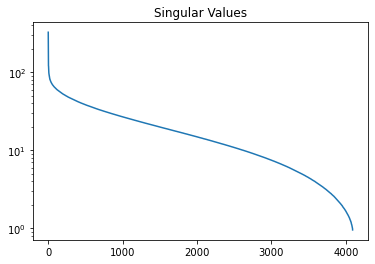

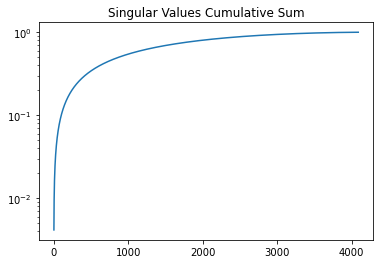

[[-0.00508805  0.00798275  0.03180521 ...  0.0211608   0.00602125
   0.05553681]
 [ 0.08397981  0.06109197  0.13084715 ...  0.33360421  0.14668214
   0.57123439]
 [ 0.00837869 -0.00123132  0.01286822 ...  0.00588874 -0.01460127
   0.03405225]
 ...
 [ 0.00627475  0.01098065  0.01381533 ...  0.03066783  0.02213099
   0.04531393]
 [ 0.02620984  0.0072356  -0.00413059 ...  0.01249215  0.00259576
  -0.00433172]
 [ 0.03099672  0.00733428 -0.0062688  ...  0.00329296 -0.00552166
  -0.03771329]]


In [48]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.semilogy(np.diag(s))
plt.title('Singular Values')
plt.show()

plt.figure(2)
plt.semilogy(np.cumsum(np.diag(s)/np.sum(np.diag(s))))
plt.title('Singular Values Cumulative Sum')
plt.show()

print(Rk_aprrox)

# Step 6

In [117]:
true_ratings = sample_data['rating'].values.astype(float).astype(int)

############################
# RMSE FOR UCF
RMSE_UCF = []
for i in range(ucf_predictions[0].size):
    predicted_ratings = np.array(ucf_predictions[:,i])
    sum_of_difference = 0
    for j in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[j] - true_ratings[j])**2
    RMSE_UCF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))
    
############################
# RMSE FOR ICF
RMSE_ICF = []
for i in range(icf_predictions[0].size):
    predicted_ratings = np.array(icf_predictions[:,i])
    sum_of_difference = 0
    for j in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[j] - true_ratings[j])**2
    RMSE_ICF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))
    
############################
# RMSE FOR MODIFIED UCF
for i in range(ucf2_predictions.shape[0]):
    for j in range(ucf2_predictions.shape[1]):
        if ucf2_predictions[i][j]<0:
            ucf2_predictions[i][j] = 0
        if ucf2_predictions[i][j]>5:
            ucf2_predictions[i][j] = 5

RMSE_UCF2 = []
for i in range(ucf2_predictions[0].size):
    predicted_ratings = np.array(ucf2_predictions[:,i])
    sum_of_difference = 0
    for j in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[j] - true_ratings[j])**2
    RMSE_UCF2.append(math.sqrt(sum_of_difference/sample_data.shape[0]))


############################
# RMSE FOR USER AVERAGE
sum_of_difference = 0
for i in range(sample_data.shape[0]):
    sum_of_difference += (user_avg_pred[i] - true_ratings[i])**2
RMSE_UA = math.sqrt(sum_of_difference/sample_data.shape[0])


############################
# RMSE FOR BUSINESS AVERAGE
sum_of_difference = 0
for i in range(sample_data.shape[0]):
    sum_of_difference += (business_avg_pred[i] - true_ratings[i])**2
RMSE_ΒΑ = math.sqrt(sum_of_difference/sample_data.shape[0])

In [118]:
results = []
results.append([min(RMSE_UCF2), 'RMSE_UCF2'])
results.append([min(RMSE_UCF), 'RMSE_UCF'])
results.append([min(RMSE_ICF), 'RMSE_ICF'])
results.append([RMSE_ΒΑ, 'RMSE_BA'])
results.append([RMSE_UA, 'RMSE_UA'])
results = sorted(results, key=itemgetter(0))
results

[[0.9816603917540054, 'RMSE_UCF2'],
 [0.9962485270367716, 'RMSE_BA'],
 [0.9988988283037591, 'RMSE_UCF'],
 [1.0277501951504682, 'RMSE_ICF'],
 [1.03340476523951, 'RMSE_UA']]

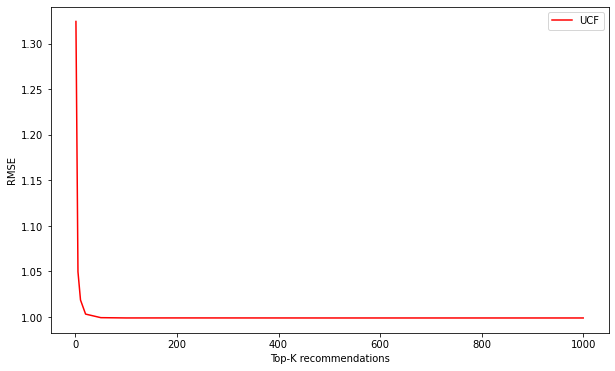

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
x = [1,5,10,20,50,100,200,500,1000]
plt.plot(x, RMSE_UCF, "r", label = "UCF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

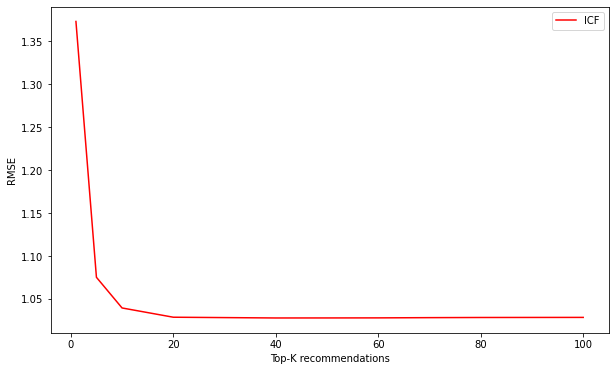

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
x = [1,5,10,20,40,50,60,70,80,100]
plt.plot(x, RMSE_ICF, "r", label = "ICF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

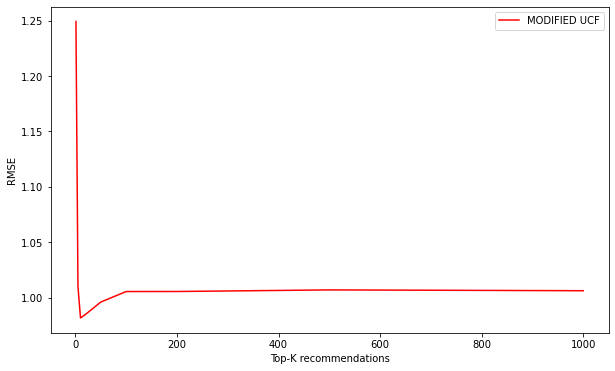

In [125]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
x = [1,5,10,20,50,100,200,500,1000]
plt.plot(x, RMSE_UCF2, "r", label = "MODIFIED UCF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");